Multiplexed sequencing
======================

The Pulsar/Cluster QRM/QCM supports six sequencers. The output of each sequencer is multiplexed, accumulated and connected to the output ports of the instrument as shown in the figure below. Furthermore, input paths 0 and 1 of every sequencer are connected to inputs $\text{I}^{1}$ and $\text{I}^{2}$ respectively. In the first part of the tutorial we will connect outputs of multiple sequencers to a single pair of output ports and demonstrate how to multiplex output paths 0 and 1 of these sequencers as well as show how these multiplexed signals are accumulated. In the second part of the tutorial we will demonstrate firstly, how to frequency multiplex the output paths of different sequencers at different unique carrier frequencies on a single pair of output ports and secondly, how to aquire, demodulated and integrate the recieved frequency multiplexed waveforms. In the third part of the tutorial we will demonstrate "real mode", where we will control various sequencers to independantly output real signals on each output port of the instrument.

We will show this by using a QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable –-py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from scipy.fft import rfft, rfftfreq

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on.


Dropdown(description='Select Device', options=('pulsar-qrm', 'pulsar-qcm'), value='pulsar-qrm')

#### Pulsar QRM <a id='pulsar_setup'></a>
If you chose the Pulsar QRM, run the following cell. Skip to the [Cluster QRM section](#cluster_setup) if you selected a Cluster module.

In [3]:
# Close existing connections to the Pulsar modules
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qrm = Pulsar(f"{device_name}", ip_address)
qrm.reset()
cluster = None  # In absence of a cluster
print(f"{device_name} connected at {ip_address}")
print(qrm.get_system_state())

pulsar-qrm connected at 192.168.0.4
Status: OKAY, Flags: NONE, Slot flags: NONE


Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster QRM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QRM section](#pulsar_setup) if you are using a Pulsar.


In [ ]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

We then find all available cluster modules to connect to them individually.

In [ ]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QRM module from the available modules in your Cluster:")
display(connect_qxm)

Finally, we connect to the selected Cluster module. 

In [ ]:
# Connect to the cluster QRM
qrm = getattr(
    cluster, connect_qxm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [4]:
# Waveforms
waveform_len = 1000
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(waveform_len, std=0.133 * waveform_len).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_len) * i) for i in range(0, waveform_len)
        ],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / waveform_len) * i for i in range(0, waveform_len)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_len)], "index": 3},
}

Let's plot the waveforms to see what we have created.

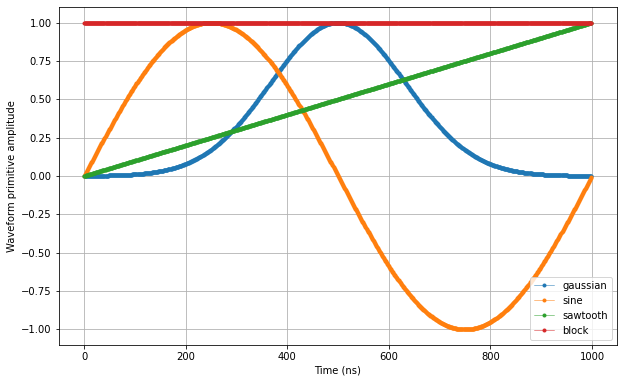

In [5]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Specify the acquisitions
--------------------

We will only use a single bin in this tutorial, so we can keep it simple

In [6]:
# Acquisitions
acquisitions = {"scope": {"num_bins": 1, "index": 0}}

Create Q1ASM program and upload the sequence
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions. In this case we will play a gaussian and a sinosoid wave for path 0 and 1 respectively per sequencer.

In [7]:
# Number of sequencers per instrument
num_seq = 6

# Program
program = """
wait_sync 4
play      0,1,4
wait      140
acquire   0,0,16380
stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

# Program sequencers.
for sequencer in qrm.sequencers:
    sequencer.sequence("sequence.json")

Multiplexed sequencer output control
------------------------------------
The output paths of each sequencer are connected to the instrument's outputs as shown in the figure below. For a QRM, path 0 of each sequencer can only be connected to output $\text{O}^{1}$ and path 1 only to output $\text{O}^{2}$ (for a QCM, path 0 can be connected to output $\text{O}^{1}$ and $\text{O}^{3}$ and path 1 to $\text{O}^{2}$ and $\text{O}^{4}$), . In order to connect the sequencer output paths to corresponding output ports, we need to configure the sequencer's channel map by calling sequencer`X`_channel_map_path`Y`_out`Z`_en where `X`, `Y` and `Z` represents sequencer ID, path ID and output port number respectively.

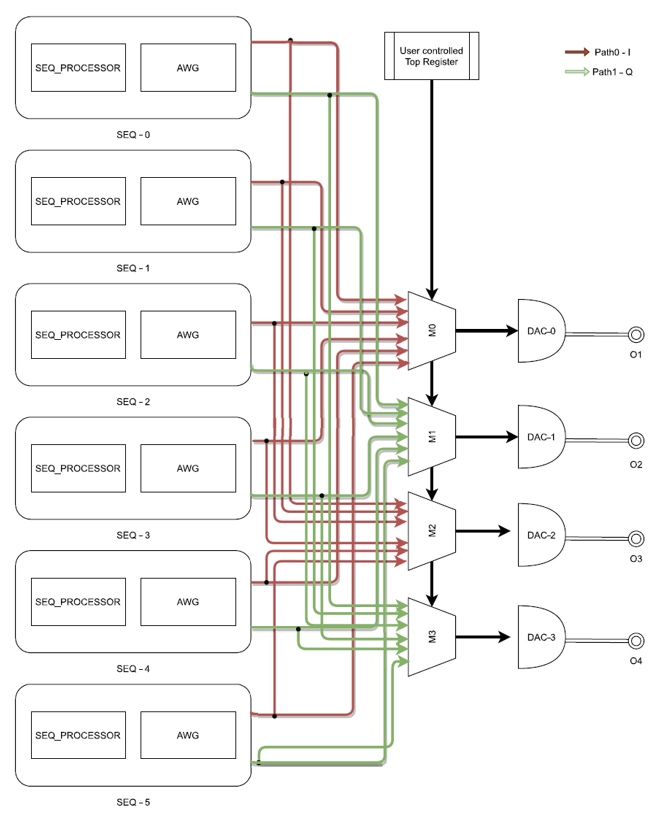

Now lets configure the first sequencer to output its paths on $\text{O}^{1}$ and $\text{O}^{2}$. We will scale the amplitude of the signal such that we are able the show what happens when other sequencers are added and eventually output overflow occurs.

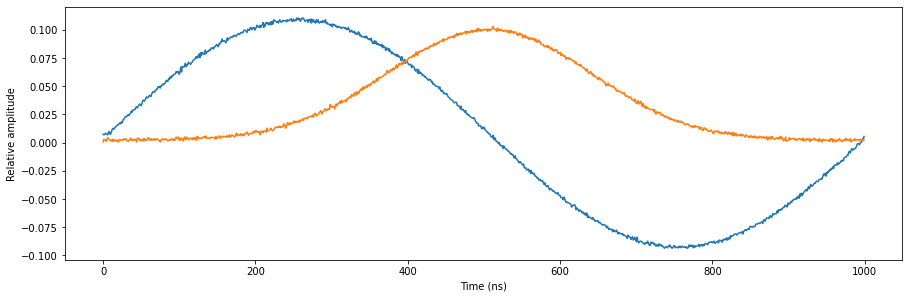

In [8]:
# Configure the sequencer to trigger the scope acquisition.
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Configure sequencer
qrm.sequencer0.sync_en(True)
qrm.sequencer0.gain_awg_path0(
    1.1 / num_seq
)  # The output range is 1.0 to -1.0, but we want to show what happens when the signals go out of range.
qrm.sequencer0.gain_awg_path1(1.1 / num_seq)
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

# Start the sequence
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop
qrm.get_acquisition_state(0, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Let's add the second sequencer.

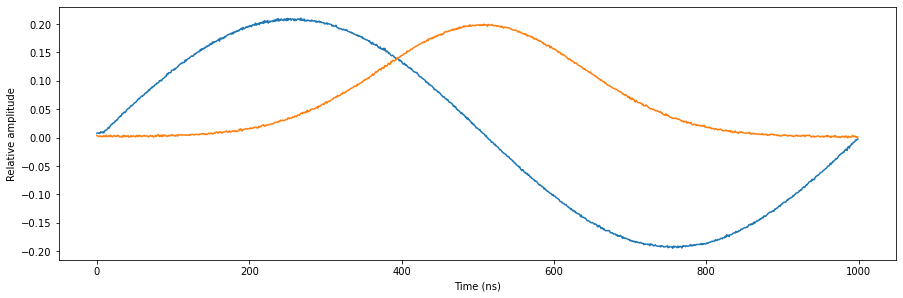

In [9]:
# Configure the sequencer
qrm.sequencer1.sync_en(True)
qrm.sequencer1.gain_awg_path0(1.1 / num_seq)
qrm.sequencer1.gain_awg_path1(1.1 / num_seq)
qrm.sequencer1.channel_map_path0_out0_en(True)
qrm.sequencer1.channel_map_path1_out1_en(True)

# Start the sequencers
for seq in range(0, 2):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 2):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Let's add the third sequencer.

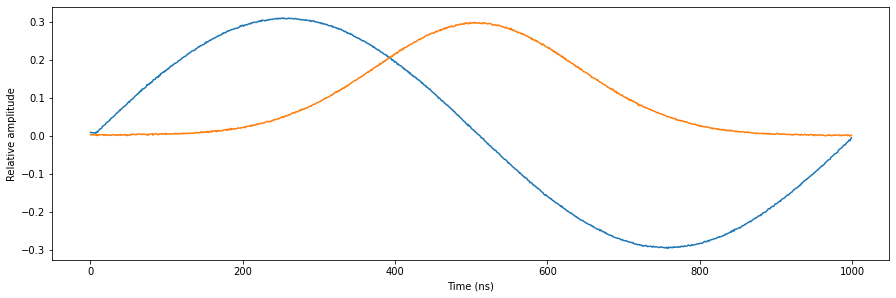

In [10]:
# Configure the sequencer
qrm.sequencer2.sync_en(True)
qrm.sequencer2.gain_awg_path0(1.1 / num_seq)
qrm.sequencer2.gain_awg_path1(1.1 / num_seq)
qrm.sequencer2.channel_map_path0_out0_en(True)
qrm.sequencer2.channel_map_path1_out1_en(True)

# Start the sequencers
for seq in range(0, 3):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 3):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Let's add the fourth sequencer.

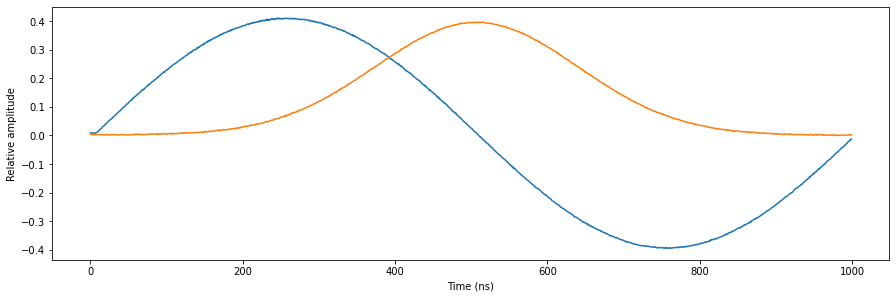

In [11]:
# Configure the sequencer
qrm.sequencer3.sync_en(True)
qrm.sequencer3.gain_awg_path0(1.1 / num_seq)
qrm.sequencer3.gain_awg_path1(1.1 / num_seq)
qrm.sequencer3.channel_map_path0_out0_en(True)
qrm.sequencer3.channel_map_path1_out1_en(True)

# Start the sequencers
for seq in range(0, 4):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 4):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Let's add the fifth sequencer.

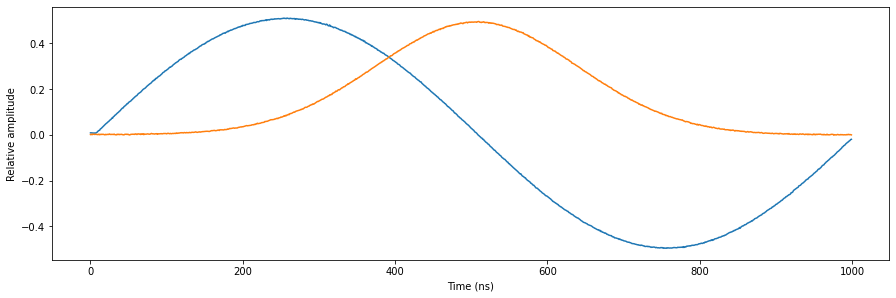

In [12]:
# Configure the sequencer
qrm.sequencer4.sync_en(True)
qrm.sequencer4.gain_awg_path0(1.1 / num_seq)
qrm.sequencer4.gain_awg_path1(1.1 / num_seq)
qrm.sequencer4.channel_map_path0_out0_en(True)
qrm.sequencer4.channel_map_path1_out1_en(True)

# Start the sequencers
for seq in range(0, 5):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 5):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Let's add the sixth sequencer.

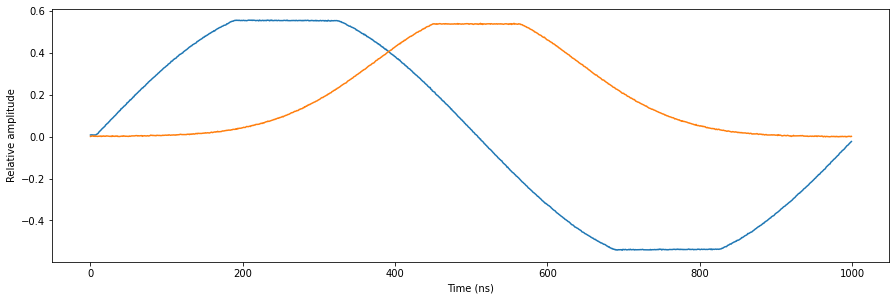

In [13]:
# Configure the sequencer
qrm.sequencer5.sync_en(True)
qrm.sequencer5.gain_awg_path0(1.1 / num_seq)
qrm.sequencer5.gain_awg_path1(1.1 / num_seq)
qrm.sequencer5.channel_map_path0_out0_en(True)
qrm.sequencer5.channel_map_path1_out1_en(True)

# Start the sequencers
for seq in range(0, 6):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 6):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

matplotlib.pyplot.show()

Note that now the outputs overflow and the output signal is clipped as intended. Also note that the output range of a QRM is 1 Vpp, while it's input range is 2 Vpp. This causes the signal in the figure to be clipped at 0.5 and -0.5.

Frequency multiplexing
----------------------
Next, we will show frequency multiplexing. We will connect the outputs of various sequencers to a single output port pair, modulate their waveforms on unique carrier frequencies and in turn acquire, demodulate and integrate the results fed back into the inputs to validate the acquired signals. In this case, for simplicity, we will modulate a square wave pulse on each sequencer and we will play with the output gain. In order to visualise the frequency multiplexing, we will preform an FFT over the acquired scope acquisitions.

In [14]:
# Reset
if cluster:
    cluster.reset()
else:
    qrm.reset()
# Program
program = """
      wait_sync 4
loop: play      3,3,4
      wait      140
      acquire   0,0,16380
      stop
"""

# Write sequence to file
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Lets start with a single sequencer with an AWG gain of 1.0 (only on path 0 to create a "real" pulse). Let's modulate it's output with a carrier frequency of 20MHz.

In [15]:
# Program sequencer
qrm.sequencer0.sequence("sequence.json")

# Configure the channel map
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

# Configure sequencer
qrm.sequencer0.sync_en(True)
qrm.sequencer0.gain_awg_path0(1.0)
qrm.sequencer0.gain_awg_path1(0.0)
qrm.sequencer0.nco_freq(20e6)
qrm.sequencer0.mod_en_awg(True)
qrm.sequencer0.demod_en_acq(True)
qrm.sequencer0.integration_length_acq(waveform_len)

In [16]:
# Start the sequencer
qrm.arm_sequencer(0)
qrm.start_sequencer(0)

# Wait for the sequencer to stop
qrm.get_acquisition_state(0, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of one tone at 20MHz.

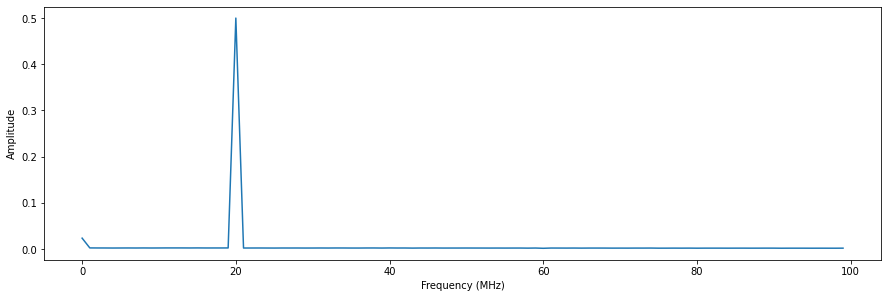

In [17]:
# Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
norm_fact = qrm.sequencer0.gain_awg_path0() / 2 / numpy.max(yf)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
matplotlib.pyplot.show()

Now let's have a look at the hardware demodulated and integrated results and check if it matches our expectations. Don't forget that we need to divide the integration results by the integration length. In this case, the integration length is the same as the waveform length.

In [18]:
bins = acq["scope"]["acquisition"]["bins"]
I = bins["integration"]["path0"][0] / waveform_len
Q = bins["integration"]["path1"][0] / waveform_len
print("Integeration results:")
print("I = {}".format(I))
print("Q = {}".format(Q))
print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))

Integeration results:
I = -0.008239863214460186
Q = -0.00370200293111871
R = sqrt(I^2 + Q^2) = 0.009033281324913206


The pulse acquired at the inputs is automatically demodulated at 20MHz, but due to phase rotation caused by output-to-input latency the result is not purely real. However the amplitude of the IQ vector is 0.5 as expected because: 1Vpp output range / 2Vpp input range = 0.5.

Now lets increase the number of sequencers to three, each with a slightly different AWG gain. We will modulate the signals of sequencer 0 to 2 with a carrier frequencies at 20MHz, 30MHz and 40MHz respectively.

In [19]:
num_seq = 3
for seq in range(0, num_seq):
    # Program sequencers
    qrm.sequencers[seq].sequence("sequence.json")

    # Configure the channel map
    qrm.sequencers[seq].channel_map_path0_out0_en(True)
    qrm.sequencers[seq].channel_map_path1_out1_en(True)

    # Configure the sequencers
    qrm.sequencers[seq].sync_en(True)
    qrm.sequencers[seq].mod_en_awg(True)
    qrm.sequencers[seq].demod_en_acq(True)
    qrm.sequencers[seq].integration_length_acq(waveform_len)

# Set the gains
qrm.sequencer0.gain_awg_path0(0.5)
qrm.sequencer0.gain_awg_path1(0.0)
qrm.sequencer1.gain_awg_path0(0.25)
qrm.sequencer1.gain_awg_path1(0.0)
qrm.sequencer2.gain_awg_path0(0.125)
qrm.sequencer2.gain_awg_path1(0.0)

# Set the frequencies
qrm.sequencer0.nco_freq(20e6)
qrm.sequencer1.nco_freq(30e6)
qrm.sequencer2.nco_freq(40e6)

In [20]:
# Start the sequencers
for seq in range(0, 3):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 3):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of three tones at 20MHz, 30Mhz and 40MHz.

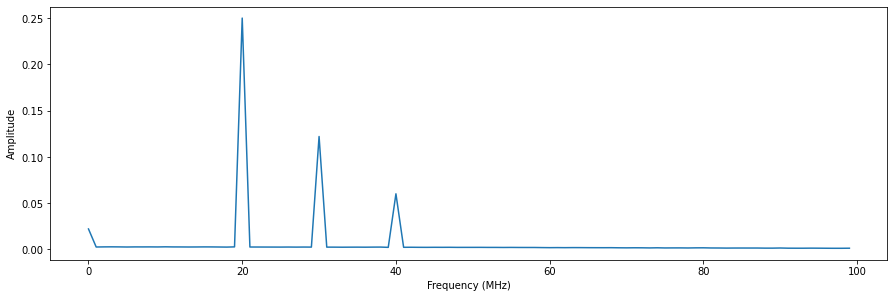

In [21]:
# Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
matplotlib.pyplot.show()

Now let's check if the hardware demodulated and integrated results match our expectations.

In [22]:
for seq in range(0, num_seq):
    qrm.store_scope_acquisition(seq, "scope")
    acq = qrm.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I = bins["integration"]["path0"][0] / waveform_len
    Q = bins["integration"]["path1"][0] / waveform_len
    print("Sequencer {}".format(seq))
    print("Integeration results:")
    print("I = {}".format(I))
    print("Q = {}".format(Q))
    print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))
    print(
        "---------------------------------------------------------------------------------"
    )

Sequencer 0
Integeration results:
I = -0.0046311675622862725
Q = -0.0015676599902296042
R = sqrt(I^2 + Q^2) = 0.0048893016715006715
---------------------------------------------------------------------------------
Sequencer 1
Integeration results:
I = -0.0034816805080605767
Q = 0.00247923790913532
R = sqrt(I^2 + Q^2) = 0.0042741922944929175
---------------------------------------------------------------------------------
Sequencer 2
Integeration results:
I = -0.002084513922813874
Q = 0.0004640937957987298
R = sqrt(I^2 + Q^2) = 0.002135551766102559
---------------------------------------------------------------------------------


Again, the acquired signals on the input are automatically demodulated at 20MHz, 30MHz and 40MHz and we see that the amplitude of the IQ vectors match the gain values we set divided by two, which matches our expectations.

Now, let's try it one final time with six sequencers, each with 0.15 AWG gain. We will modulate the outputs of sequencer 0 to 5 with carrier frequencies at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz respectivey.

In [23]:
num_seq = 6
for seq in range(0, num_seq):
    # Program sequencers
    qrm.sequencers[seq].sequence("sequence.json")

    # Configure the channel map
    qrm.sequencers[seq].channel_map_path0_out0_en(True)
    qrm.sequencers[seq].channel_map_path1_out1_en(True)

    # Configure the sequencers
    qrm.sequencers[seq].sync_en(True)
    qrm.sequencers[seq].gain_awg_path0(0.15)
    qrm.sequencers[seq].gain_awg_path1(0.0)
    qrm.sequencers[seq].mod_en_awg(True)
    qrm.sequencers[seq].demod_en_acq(True)
    qrm.sequencers[seq].integration_length_acq(waveform_len)

# Set the frequencies
qrm.sequencer0.nco_freq(20e6)
qrm.sequencer1.nco_freq(30e6)
qrm.sequencer2.nco_freq(40e6)
qrm.sequencer3.nco_freq(50e6)
qrm.sequencer4.nco_freq(60e6)
qrm.sequencer5.nco_freq(70e6)

In [24]:
# Start the sequencers
for seq in range(0, 6):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 6):
    qrm.get_acquisition_state(seq, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of six tones at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz

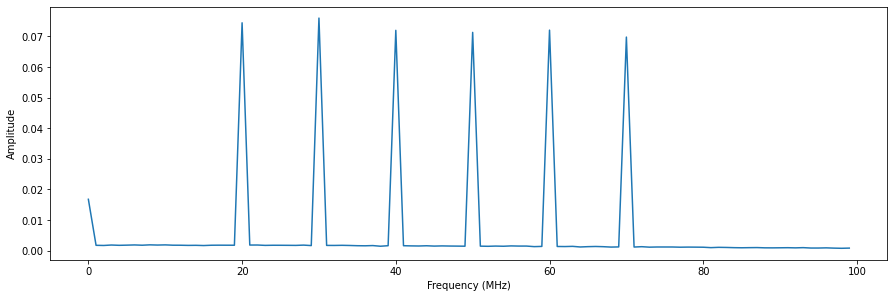

In [25]:
# Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
matplotlib.pyplot.show()

Note that we lose a little bit of power over the frequency range, but that is to be expected due to frequency dependant components in the output and input path. Now let's check if the hardware demodulated and integrated results match our expectations.

In [26]:
for seq in range(0, num_seq):
    qrm.store_scope_acquisition(seq, "scope")
    acq = qrm.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I = bins["integration"]["path0"][0] / waveform_len
    Q = bins["integration"]["path1"][0] / waveform_len
    print("Sequencer {}".format(seq))
    print("Integeration results:")
    print("I = {}".format(I))
    print("Q = {}".format(Q))
    print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))
    print(
        "---------------------------------------------------------------------------------"
    )

Sequencer 0
Integeration results:
I = -0.001826086956521739
Q = -0.0006306790425012213
R = sqrt(I^2 + Q^2) = 0.0019319289913009444
---------------------------------------------------------------------------------
Sequencer 1
Integeration results:
I = -0.0015329750854909622
Q = 0.0002892037127503664
R = sqrt(I^2 + Q^2) = 0.001560016474337569
---------------------------------------------------------------------------------
Sequencer 2
Integeration results:
I = -0.0012208109428431852
Q = 0.0026722032242305813
R = sqrt(I^2 + Q^2) = 0.0029378647739053583
---------------------------------------------------------------------------------
Sequencer 3
Integeration results:
I = 0.001172447484123107
Q = 0.002017098192476795
R = sqrt(I^2 + Q^2) = 0.002333091987282061
---------------------------------------------------------------------------------
Sequencer 4
Integeration results:
I = 0.003261846604787494
Q = 0.0005994137762579385
R = sqrt(I^2 + Q^2) = 0.0033164650078557293
------------------------

Taking the power loss over frequency into account, the amplitudes of the IQ vectors match our expectations again.

Real mode
---------------

Many applications require multiple outputs to be controlled independantly and only output real signals instead of a modulated IQ pair. To achieve this we will connect one sequencer to each output and only use path 0 to control an even numbered output and path 1 to control an odd numbered output. To demonstrate this, we will simply output an independantly timed sine on output $\text{O}^{1}$ and a sawtooth on output $\text{O}^{2}$, which we will then acquire on the inputs.

Lets create a Q1ASM program to sequence the waveforms for sequencer 0.

In [27]:
# Reset
if cluster:
    # reset entire cluster
    cluster.reset()
else:
    # reset the pulsar module
    qrm.reset()
# Program
program = """
wait_sync 4
play      1,1,4
wait      140
acquire   0,0,16380
stop
"""

# Write sequence to file
with open("sequence0.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Lets create a Q1ASM program to sequence the waveforms for sequencer 1.

In [28]:
# Program
program = """
wait_sync 4
wait      500
play      2,2,1000
stop
"""

# Write sequence to file
with open("sequence1.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Let's configure both sequencers and connect them to their respective outputs.

In [29]:
# Configure scope mode
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Program sequencer
num_seq = 2
for seq in range(0, num_seq):
    qrm.sequencers[seq].sequence("sequence{}.json".format(seq))

# Configure the channel map
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer1.channel_map_path1_out1_en(True)

# Configure sequencer
for seq in range(0, num_seq):
    qrm.sequencers[seq].sync_en(True)
    qrm.sequencers[seq].mod_en_awg(False)

qrm.sequencer0.gain_awg_path1(
    0.0
)  # Disable sequencer 0 path 1, because we will not use it.
qrm.sequencer1.gain_awg_path0(
    0.0
)  # Disable sequencer 1 path 0, because we will not use it.

Now, let start the sequencers and visualise the resulting sequence.

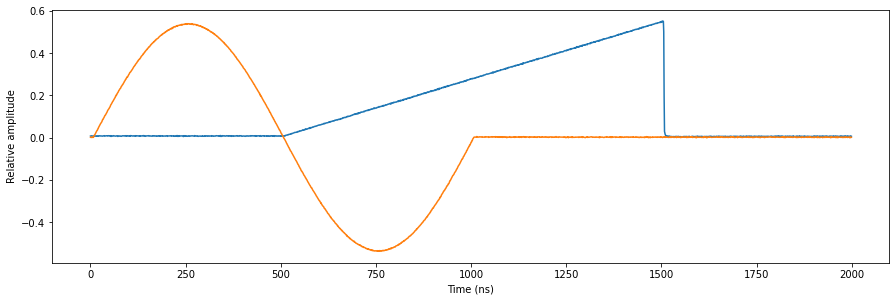

In [30]:
# Start sequencers
for seq in range(0, num_seq):
    qrm.arm_sequencer(seq)
qrm.start_sequencer()

# Wait for sequencers to stop (only sequencer 0 will acquire)
for seq in range(0, num_seq):
    qrm.get_sequencer_state(seq, 1)
qrm.get_acquisition_state(0, 1)

# Get acquisition
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

# Plot result
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:2000])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:2000])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

As expected, we see a sine and sawtooth that are independantly sequenced on the outputs.

Stop
----

Finally, let's close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connection.
# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()